In [7]:
!pip install --upgrade git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-6q8gs8mq
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-6q8gs8mq
  Resolved https://github.com/huggingface/transformers to commit 5fabebdb7d4f9ee5a6459f7c0dcde0b1901f6205
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.40.0.dev0-py3-none-any.whl size=8926349 sha256=4b55a506f521af8210cd0cbb4a0c56c51adce1760902fa92e4ceee2a3191f167
  Stored in directory: /tmp/pip-ephem-wheel-cache-pifuglot/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [8]:
!pip install setfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 409.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (41

# EDA

In [9]:
import pandas as pd
import numpy as np


np.random.seed(3)
fname = "drive/MyDrive/canoe-mle-take-home-dataset.parquet"
data = pd.read_parquet(fname)
data = data.dropna()
data = data.sample(n=len(data))
data["combined_levels"] = data.apply(lambda x: x["l1"] + x["l2"] + x["l3"], axis=1)

data.shape


(196286, 5)

In [10]:
data.head()

,text,l1,l2,l3,combined_levels
179171,Prestongrange Museum is an industrial heritage...,Place,Building,Museum,PlaceBuildingMuseum
44799,"Liang Court (Simplified Chinese: 亮阁, Tradition...",Place,Building,ShoppingMall,PlaceBuildingShoppingMall
95144,Onoba kergueleni is a species of minute sea sn...,Species,Animal,Mollusca,SpeciesAnimalMollusca
95035,Blessed Francesco Lippi (3 December 1211 – 11 ...,Agent,Cleric,Saint,AgentClericSaint
145769,Brad Armstrong (born Rod Hopkins; September 23...,Agent,Actor,AdultActor,AgentActorAdultActor


In [11]:
print(len(data["l1"].unique()))
print(len(data["l2"].unique()))
print(len(data["l3"].unique()))


9
70
219


# We'll try approaching this as a highly multiclass classifier, so combine l1+l2+l3, each combination is a class, there's 219 total classes.

In [90]:
data["combined_levels"] = data.apply(lambda x: x["l1"] + x["l2"] + x["l3"], axis=1)
len(data["combined_levels"].unique())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


219

<BarContainer object of 219 artists>

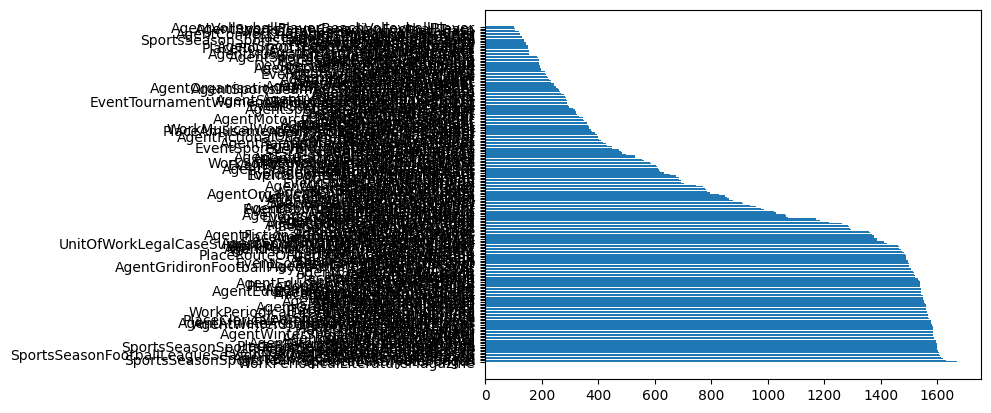

In [12]:
# Messy look at the distribution of samples, there's a lot of categories with > 1000 examples and a lot with only a few hundred.

import matplotlib.pyplot as plt

classes = sorted(list(data["combined_levels"].unique()))

fig, ax = plt.subplots()
ax.barh(data["combined_levels"].value_counts().index, data["combined_levels"].value_counts(),align='center')

In [ ]:
# One class has as little as 102 examples, not a lot of data to work with training wise.  We need can work with few examples.
data["combined_levels"].value_counts().quantile([0, .25,.5,.75, 1])

0.00     102.0
0.25     319.0
0.50     829.0
0.75    1527.5
1.00    1671.0
Name: count, dtype: float64

# Model selection + Prep text
We're going to use something called setfit which basically takes sentence embedding models and turns them into few shot classifiers.  Why?  Anecdotally has shown promise for large number of classes classification scenarios, but more importantly for some classes we have only ~100 examples to go off of, so we need to use a model that doesn't need much training data, which is exactly what SetFit was made for.
1.   Downsample each class to only 4 examples.  Crazy? Yes, BUT we're going to use [Setfit](https://github.com/huggingface/setfit) which is designed for few shot learning.  We could do more but with so many classes and my current compute limitations training is going to take forever with more examples so we're sticking with 4 per class.  We'll have more examples in the test and eval sets (ironically) because we want to actually get an idea for how the model is performing.
1.   Truncate texts to first 2 sentences - longer sentences = longer training time and most of the most relevant information seems to be in first two sentences anyway.
2.   Encode labels
3.   Split into train/eval/test datasets -
3.   Convert into huggingface dataset and randomize order




In [35]:
from datasets import Dataset
from spacy.lang.en import English


nlp = English()
nlp.add_pipe("sentencizer")
text="Please read the analysis. (You'll be amazed.). Here here"
doc = nlp(text)


def truncate_sents(x):
  # longer texts = longer training time
  # most of the useful information in first sent or two anyway
  doc = nlp(x)
  return " ".join([str(s) for s in doc.sents][:2])


def clean_split_x_y(dset, max_char=400):   # longer texts = longer training time, shorten for we
  x = dset["text"].apply(lambda x: truncate_sents(x)[:max_char])
  y = dset["combined_levels"]
  y = y.map(encode_label)
  return x, y


def encode_label(record):
  return classes.index(record)


downsampled = data.groupby("combined_levels").apply(lambda x: x.sample(100)).reset_index(drop="true")
downsampled_train = downsampled.groupby("combined_levels").apply(lambda x: x[:4]).reset_index(drop="true")
downsampled_eval = downsampled.groupby("combined_levels").apply(lambda x: x[8:50]).reset_index(drop="true")
downsampled_test = downsampled.groupby("combined_levels").apply(lambda x: x[50:100]).reset_index(drop="true")


train_x, train_y = clean_split_x_y(downsampled_train)
eval_x, eval_y = clean_split_x_y(downsampled_eval)
test_x, test_y = clean_split_x_y(downsampled_test)

train_dataset = Dataset.from_dict({"text": train_x, "labels": train_y}).shuffle()
eval_dataset = Dataset.from_dict({"text": eval_x, "labels": eval_y}).shuffle()
test_dataset = Dataset.from_dict({"text": test_x, "labels": test_y}).shuffle()




In [91]:
# sample of what our new texts look like post truncation
train_dataset["text"][1]

'Village of Belle Terre v. Boraas, 416 U.S. 1 (1974) is a United States Supreme Court case in which the Court upheld the constitutionality of a residential zoning ordinance that limited the number of unrelated individuals who may inhabit a dwelling.'

In [92]:
print(len(train_dataset["labels"]))
print(len(eval_dataset["labels"]))
print(len(test_dataset["labels"]))

876
9198
10950


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
# Post truncation our texts are much smaller, most are 200ish characters instead of > 1000 which will speed things up.

from statistics import median, mean

print(max(train_dataset.to_pandas()["text"].apply(lambda x: len(x))))
print(median(train_dataset.to_pandas()["text"].apply(lambda x: len(x))))

400
213.5


# Model training

In [37]:
# I don't have the time or compute resources to do more than one training run here so no hyperparam tuning today.

from datasets import load_dataset, Dataset
from setfit import SetFitTrainer
from setfit import SetFitModel, Trainer, TrainingArguments, sample_dataset
from sentence_transformers.losses import CosineSimilarityLoss


model = SetFitModel.from_pretrained(
    "sentence-transformers/all-MiniLM-L6-v2",
    labels=classes,
)

args = TrainingArguments(
    batch_size=16,
    num_epochs=2,
    num_iterations=4,
    end_to_end=False,
    body_learning_rate=2e-5,
    l2_weight=0.01,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    column_mapping={"text": "text", "labels": "label"}

)

# train/eval
trainer.train()
trainer.model._save_pretrained(save_directory="drive/MyDrive/canoe_proj/setfit_model")
metrics = trainer.evaluate(test_dataset)
print(metrics)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to the training dataset


Map:   0%|          | 0/876 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 7008
  Batch size = 16
  Num epochs = 2
  Total optimization steps = 876


Step,Training Loss


Applying column mapping to the evaluation dataset
***** Running evaluation *****


{'accuracy': 0.8757990867579909}


In [96]:
trainer.model.push_to_hub("mcllstr/setfit-mltclss")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model_head.pkl:   0%|          | 0.00/677k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/mcllstr/setfit-mltclss/commit/38ebbddd1b7e2d3d3575a0e788af4ba106e6ca70', commit_message='Push model using huggingface_hub.', commit_description='', oid='38ebbddd1b7e2d3d3575a0e788af4ba106e6ca70', pr_url=None, pr_revision=None, pr_num=None)

In [102]:
train_dataset.save_to_disk("drive/MyDrive/canoe_proj/datasets/train_dataset.hf")
eval_dataset.save_to_disk("drive/MyDrive/canoe_proj/datasets/eval_dataset.hf")
test_dataset.save_to_disk("drive/MyDrive/canoe_proj/datasets/test_dataset.hf")

Saving the dataset (0/1 shards):   0%|          | 0/876 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9198 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10950 [00:00<?, ? examples/s]

# Performance
For a model attempting to classify 219 classes with only 10 training examples for each class and no hyperparameter tuning we're doing well.
For simplicity let's focus on F1 (precision and recall are also computed below, their performance is similar).


* More than half of all the classes have more than a 90% F1 score.  
* Our average f1 is 87% across all classes.
* More than 80% of classes exceed 80% f1
* Only ~10% of our classes have f1 performance below 70%.

For the fraction of classes not performing well, we can analyze further to see if there is a pattern (eg is there concept confusion, is this specific to certain L1/L2 clusters?).  
To improve performance (depending on this analysis) we might try
1. try combining certain lower performing categories if there is identifiable concept leak between classes and if appropriate for whatever consumes these predictions downstream
2. upsample training data for these classes
3. hyperparameter tuning

In [101]:
from setfit import SetFitModel
from Datasets import Dataset

# Load the model from huggingface
model = SetFitModel.from_pretrained("mcllstr/setfit-mltclss")
# Load dataset from disk
test_dataset = Dataset.from_disk("drive/MyDrive/canoe_proj/datasets/test_dataset.hf")

In [50]:
from sklearn.metrics import classification_report

y_true = [classes[x]for x in test_dataset["labels"]]
y_pred = model(test_dataset["text"])

# Generate classification report
report = classification_report(y_true, y_pred)
print(report)


                                                              precision    recall  f1-score   support

                                        AgentActorAdultActor       0.93      0.80      0.86        50
                                        AgentActorVoiceActor       0.74      1.00      0.85        50
                                         AgentArtistComedian       0.96      0.92      0.94        50
                                    AgentArtistComicsCreator       0.95      0.76      0.84        50
                                  AgentArtistFashionDesigner       0.89      0.94      0.91        50
                                          AgentArtistPainter       0.91      0.96      0.93        50
                                     AgentArtistPhotographer       0.94      0.96      0.95        50
                   AgentAthleteAustralianRulesFootballPlayer       0.73      0.96      0.83        50
                                 AgentAthleteBadmintonPlayer       1.00      0.98

In [89]:
from sklearn.metrics import f1_score, precision_score, recall_score

f1s = f1_score(y_true, y_pred, average=None)
precisions = precision_score(y_true, y_pred, average=None)
recalls = recall_score(y_true, y_pred, average=None)


greater_than_90 = len([x for x in precisions if x > .9]) / len(precisions) * 100
greater_than_80 = len([x for x in precisions if x > .8]) / len(precisions) * 100
less_than_70 = len([x for x in precisions if x < .7]) / len(precisions) * 100
print("precision")
print(f"\tPercent classes greater than 90%: {greater_than_90}%")
print(f"\tPercent classes greater than 80%: {greater_than_80}%")
print(f"\tPercent classes less than 70%:    {less_than_70}%")


greater_than_90 = len([x for x in recalls if x > .9]) / len(recalls) * 100
greater_than_80 = len([x for x in recalls if x > .8]) / len(recalls) * 100
less_than_70 = len([x for x in recalls if x < .7]) / len(recalls) * 100
print(f"recall")
print(f"\tPercent classes greater than 90%: {greater_than_90}%")
print(f"\tPercent classes greater than 80%: {greater_than_80}%")
print(f"\tPercent classes less than 70%:   {less_than_70}%")


greater_than_90 = len([x for x in f1s if x > .9]) / len(f1s) * 100
greater_than_80 = len([x for x in f1s if x > .8]) / len(f1s) * 100
less_than_70 = len([x for x in f1s if x < .7]) / len(f1s) * 100
print("f1")
print(f"\tPercent classes greater than 90%: {greater_than_90}%")
print(f"\tPercent classes greater than 80%: {greater_than_80}%")
print(f"\tPercent classes less than 70%:    {less_than_70}%")

precision
	Percent classes greater than 90%: 60.73059360730594%
	Percent classes greater than 80%: 81.27853881278538%
	Percent classes less than 70%:   7.76255707762557%
recall
	Percent classes greater than 90%: 60.73059360730594%
	Percent classes greater than 80%: 78.53881278538812%
	Percent classes less than 70%:   12.785388127853881%
f1
	Percent classes greater than 90%: 56.62100456621004%
	Percent classes greater than 80%: 80.36529680365297%
	Percent classes less than 70%:    9.58904109589041%
